# PUBG FINAL PLACEMENT PREDICTION


In [2]:
import os



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import gc
from random import sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

/kaggle/input/pubg-version-3/mock_up.csv
/kaggle/input/pubg-version-3/test_up.csv
/kaggle/input/pubg-version-3/train_up.csv


In [3]:
# Importing the datasets and storing it in the pandas data frame 

train_df = pd.read_csv("/kaggle/input/pubg-version-3/train_up.csv")
test_df = pd.read_csv("/kaggle/input/pubg-version-3/test_up.csv")

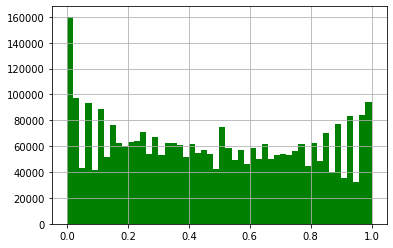

In [4]:
train_df['winPlacePerc'].hist(bins=50, color='green')
plt.show()


We can see from the graph that winning percentile distribution is not uniform , there are more count of players at the lower percentiles.

# Preprocessing
Checking for missing data or null values.

In [5]:
train_df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [6]:
train_df=train_df.dropna()

In [7]:
train_df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

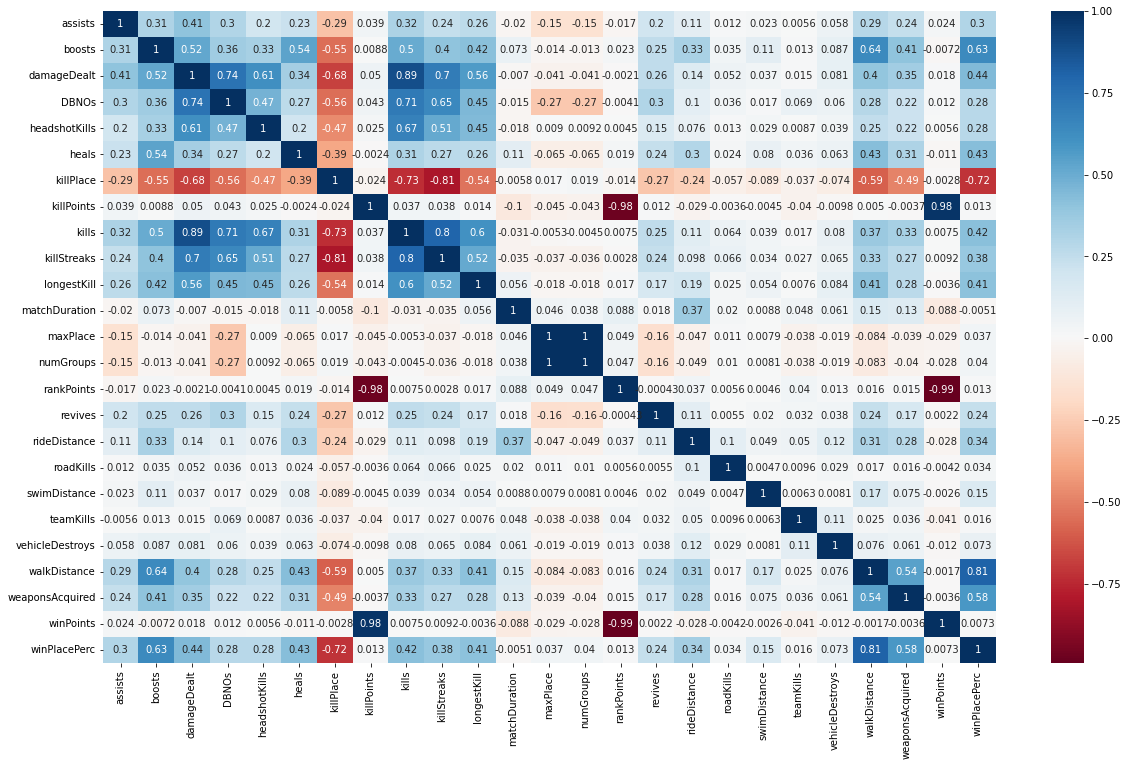

In [8]:
plt.subplots(figsize=(20,12))
dataplot = sns.heatmap(train_df.corr(), cmap="RdBu", annot=True)

## Feature Engineering
Here, some new features are constructed using existing ones.

In [9]:
train_df['belongs']= 'train'
test_df['belongs']= 'test'
df= pd.concat([train_df.drop('winPlacePerc', axis= 1), test_df], axis= 0, ignore_index= True)

In [10]:
def feat_eng(df):
    df['killRate']= df['kills']/ df['matchDuration']
    df['DBNORate']= df['DBNOs']/ df['matchDuration']
    df['entryCount']= 1
    df['total_players_match']= df.groupby(['matchId'])['entryCount'].transform(np.sum)
    df['total_players_group']= df.groupby(['groupId'])['entryCount'].transform(np.sum)
    df['killPlacePerc']= (df['killPlace']/ df['total_players_match'])
    df.loc[df['killPoints']== 0, 'killPoints']= 1
    df['maxKillPointsMatch']= df.groupby(['matchId'])['killPoints'].transform(np.max)
    df['maxKillPointsGroup']= df.groupby(['groupId'])['killPoints'].transform(np.max)
    df['ratioMatchKillPoints']= df['killPoints']/ df['maxKillPointsMatch']
    df['ratioGroupKillPoints']= df['killPoints']/ df['maxKillPointsGroup']
    df['killPointsBuckets']= pd.cut(df['killPoints'], bins= [0, 220, 450, 650, 870, 1100, 1300, 1500, 1750, 1900, 2200], labels= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], include_lowest= True)
    df['killPointsBuckets']= df['killPointsBuckets'].astype(np.int8)
    df.loc[df['winPoints']== 0, 'winPoints']= 1
    df['maxWinPointsMatch']= df.groupby(['matchId'])['winPoints'].transform(np.max)
    df['maxWinPointsGroup']= df.groupby(['groupId'])['winPoints'].transform(np.max)
    df['ratioMatchWinPoints']= df['winPoints']/ df['maxKillPointsMatch']
    df['ratioGroupWinPoints']= df['winPoints']/ df['maxKillPointsGroup']
    df['winPointsBuckets']= pd.cut(df['winPoints'], bins= [0, 200, 403, 604, 806, 1007, 1208, 1409, 1610, 1811, 2020], labels= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], include_lowest= True)
    df['winPointsBuckets']= df['winPointsBuckets'].astype(np.int8)
    df['killPointsSumMatch']= df.groupby(['matchId'])['killPoints'].transform(np.sum)
    df['killPointsSumGroup']= df.groupby(['groupId'])['killPoints'].transform(np.sum)
    df['ratioKillPointsGroupAndMatch']= df['killPointsSumGroup']/ df['killPointsSumMatch'] 
    df['avgKillPointsGroup']= df.groupby(['matchId'])['killPoints'].transform(np.mean)
    df['avgKillPointsMatch']= df.groupby(['groupId'])['killPoints'].transform(np.mean)
    df['ratioAvgKillPointsGroupAndMatch']= df['avgKillPointsGroup']/ df['avgKillPointsMatch'] 
    df['groupRevived']= df.groupby(['groupId'])['revives'].transform(np.sum)
    df['groupTeamKills']= df.groupby(['groupId'])['teamKills'].transform(np.sum)
    df['avgSpeed']= (df['walkDistance']+ df['swimDistance']+ df['rideDistance'])/ df['matchDuration']


In [11]:
feat_eng(df)

In [12]:
le= LabelEncoder()
le.fit(df['matchType'])
df['matchTypeLabels']= le.fit_transform(df['matchType'])

In [13]:
df.drop(['entryCount', 'groupId', 'matchId', 'matchType', 'DBNOs',
         'winPoints', 'killPoints', 'killStreaks', 'maxKillPointsGroup', 
         'revives', 'headshotKills', 'teamKills', 'roadKills', 'vehicleDestroys'], 
         axis= 1, inplace= True)
df.set_index('Id', inplace= True)

In [14]:
train_df= df[df['belongs']== 'train']
test_df= df[df['belongs']== 'test']
train_df.drop('belongs', axis= 1, inplace= True)
test_df.drop('belongs', axis= 1, inplace= True)
train_df.reset_index(inplace= True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
train_df['winPlacePerc']= pd.read_csv('/kaggle/input/pubg-version-3/train_up.csv', usecols= ['winPlacePerc'])
train_df.set_index('Id', inplace= True)
train_df.dropna(inplace= True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Linear Multiple, Ridge, Lasso and SV Regression

## Linear Multiple Regression

In [16]:
lr_df = train_df
X = lr_df.drop('winPlacePerc', axis=1)
y = lr_df['winPlacePerc']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [17]:
def linear_reg(X_train, X_test, y_train, y_test):
    model=LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    print('mse: ', mean_squared_error(y_test, predictions))
    print('mae: ', mean_absolute_error(y_test, predictions))

In [18]:
linear_reg(X_train, X_test, y_train, y_test)

mse:  0.09337316785585768
mae:  0.26547362405712877


In [20]:
del lr_df

NameError: name 'lr_df' is not defined

## Ridge Regression

In [22]:
ridge_df = train_df
scaler = StandardScaler()
X = ridge_df.drop('winPlacePerc', axis=1)
y = ridge_df['winPlacePerc']
scaled_X = scaler.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=101)

In [24]:
def ridge_reg(X_train, X_test, y_train, y_test):
    model = Ridge(alpha = 0.5, tol = 0.001, solver ='auto', random_state = 42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    print('mse: ', mean_squared_error(y_test, predictions))
    print('mae: ', mean_absolute_error(y_test, predictions))

In [25]:
ridge_reg(X_train, X_test, y_train, y_test)

mse:  0.0933731672804185
mae:  0.26547362399412155


In [26]:
del ridge_df

## Lasso Regression

In [27]:
lasso_df = train_df
X = lasso_df.drop('winPlacePerc', axis=1)
y = lasso_df['winPlacePerc']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [29]:
def lasso_reg(X_train, X_test, y_train, y_test):
    model = Lasso(alpha = 0.5, tol = 0.001, random_state = 42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    print('mse: ', mean_squared_error(y_test, predictions))
    print('mae: ', mean_absolute_error(y_test, predictions))

In [30]:
lasso_reg(X_train, X_test, y_train, y_test)

mse:  0.09355569180142732
mae:  0.26584751239724963


In [31]:
del lasso_df

## Support Vector Regression

In [32]:
svr_df = train_df
X = svr_df.drop('winPlacePerc', axis=1)
y = svr_df['winPlacePerc']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [34]:
def svr(X_train, X_test, y_train, y_test):
    regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    regr.fit(X_train, y_train)
    
    predictions = regr.predict(X_test)
    
    print('mse: ', mean_squared_error(y_test, predictions))
    print('mae: ', mean_absolute_error(y_test, predictions))

In [ ]:
svr(X_train, X_test, y_train, y_test)

In [ ]:
del svr_df

#  Light GBM  Model

In [22]:
lgb_df = train_df
X = lgb_df.drop('winPlacePerc', axis=1)
y = lgb_df['winPlacePerc']

x_test = test_df

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7)

In [23]:
RANDOM_STATE=212
TARGET = 'winplaceperc'
TRAIN_SIZE = 0.9
EARLY_STOP_ROUNDS = 10

lgbm = LGBMRegressor(objective='mae', n_estimators=500,  
                     learning_rate=0.3, num_leaves=200, 
                     n_jobs=-1,  random_state=RANDOM_STATE, verbose=1)


lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)], 
         eval_metric=['mse', 'mae'], early_stopping_rounds=EARLY_STOP_ROUNDS, 
         verbose=1)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.086117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6759
[LightGBM] [Info] Number of data points in the train set: 2179011, number of used features: 39
[LightGBM] [Info] Start training from score 0.458300
[1]	valid_0's l2: 0.0937873	valid_0's l1: 0.265934
[2]	valid_0's l2: 0.0935562	valid_0's l1: 0.264996
[3]	valid_0's l2: 0.0935999	valid_0's l1: 0.264518
[4]	valid_0's l2: 0.093751	valid_0's l1: 0.264294
[5]	valid_0's l2: 0.0939083	valid_0's l1: 0.264174
[6]	valid_0's l2: 0.0940493	valid_0's l1: 0.264121
[7]	valid_0's l2: 0.094171	valid_0's l1: 0.264096
[8]	valid_0's l2: 0.094262	valid_0's l1: 0.264074
[9]	valid_0's l2: 0.0943264	valid_0's l1: 0.26407
[10]	valid_0's l2: 0.0943832	valid_0's l1: 0.264072
[11]	valid_0's l2: 0.0944314	valid_0's l1: 0.264082
[12]	valid_0's l2: 0.0944763	valid_0's l1: 0.264093


LGBMRegressor(learning_rate=0.3, n_estimators=500, num_leaves=200,
              objective='mae', random_state=212, verbose=1)

In [24]:
dict = lgbm.evals_result_
print('mse: ', dict['valid_0']['l2'][len(dict['valid_0']['l2']) - 1])
print('mae: ', dict['valid_0']['l1'][len(dict['valid_0']['l1']) - 1])
    

mse:  0.0944762683688704
mae:  0.264092703164138


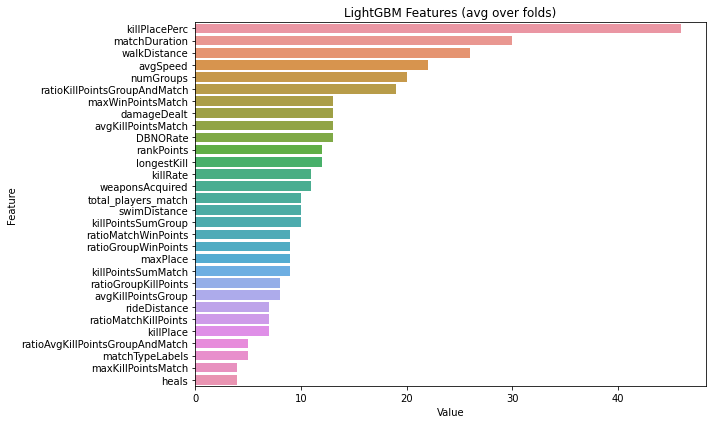

In [26]:
cols_to_drop = ['winPlacePerc']
cols_to_fit = [col for col in X_train.columns if col not in cols_to_drop]
feature_importance = pd.DataFrame(sorted(zip(lgbm.feature_importances_, cols_to_fit)), columns=['Value','Feature'])
feature_importance = feature_importance.tail(30)


plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [46]:
y_pred= lgbm.predict(x_test)

In [53]:
predictions = np.clip(a = y_pred, a_min = 0.0, a_max = 1.0)
lgbm_pred_df = pd.DataFrame({'winPlacePerc': predictions}, index=test_df.index)

## XGBoost Model

In [17]:
X_train, X_test, y_train, y_test= train_test_split(train_df.drop(['winPlacePerc'], axis= 1), train_df['winPlacePerc'], test_size= 0.3)

In [18]:
model= XGBRegressor(n_estimators= 650, max_depth= 7, n_jobs= -1, min_child_weight= 7,
                    subsample=0.84, colsample_bytree= 0.97, eta=0.3, seed=42)

In [ ]:
model.fit(
    X_train, 
    y_train, 
    eval_metric=['rmse'], 
    eval_set=[(X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 5)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:0.30679
[1]	validation_0-rmse:0.30593
[2]	validation_0-rmse:0.30547
[3]	validation_0-rmse:0.30524
[4]	validation_0-rmse:0.30510
[5]	validation_0-rmse:0.30502
[6]	validation_0-rmse:0.30496
[7]	validation_0-rmse:0.30493
[8]	validation_0-rmse:0.30490
[9]	validation_0-rmse:0.30488
[10]	validation_0-rmse:0.30485
[11]	validation_0-rmse:0.30484
[12]	validation_0-rmse:0.30482
[13]	validation_0-rmse:0.30480
[14]	validation_0-rmse:0.30479
[15]	validation_0-rmse:0.30478
[16]	validation_0-rmse:0.30477
[17]	validation_0-rmse:0.30476
[18]	validation_0-rmse:0.30475
[19]	validation_0-rmse:0.30473
[20]	validation_0-rmse:0.30472
[21]	validation_0-rmse:0.30470
[22]	validation_0-rmse:0.30469
[23]	validation_0-rmse:0.30468
[24]	validation_0-rmse:0.30467
[25]	validation_0-rmse:0.30466
[26]	validation_0-rmse:0.30465
[27]	validation_0-rmse:0.30465
[28]	validation_0-rmse:0.30464
[29]	validation_0-rmse:0.30463
[30]	validation_0-rmse:0.30461
[31]	validation_0-rmse:0.30459
[32]	validation_0-

In [62]:
xgb_pred_df= pd.DataFrame({'winPlacePerc': model.predict(test_df).clip(0,1)}, index= test_df.index)

,winPlacePerc
Id,
a5e44e9ccbd861,0.413262
ec09f9f5c29d75,0.537952
fe603d927d7792,0.459031
f7aa0b9da441b1,0.523295
bcd3f9cb689f6c,0.444503
